In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
print(save_filename)
print(time.ctime(os.path.getmtime(save_filename)))
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_binary_withintask.npy
Wed Aug 14 23:11:22 2024


dict_keys(['acc_bytask', 'dprime_bytask', 'preds_all', 'probs_all', 'acc_each_cval', 'best_cval', 'roi_names'])

In [5]:
dec_withintask['acc_bytask'].shape

(10, 8, 4, 3)

In [6]:
save_filename = os.path.join(save_folder, 'decode_binary_withintask_permutationtest.npy')
print(save_filename)
print(time.ctime(os.path.getmtime(save_filename)))
dec_withintask_shuff = np.load(save_filename, allow_pickle=True).item()

n_iter = dec_withintask_shuff['acc_bytask'].shape[4]

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_binary_withintask_permutationtest.npy
Mon Sep  9 02:52:06 2024


In [7]:
dec_withintask_shuff['acc_bytask'].shape

(10, 8, 4, 3, 1000)

In [8]:
print(dec_withintask['best_cval'].shape)
np.nanmedian(dec_withintask['best_cval'].ravel())

(10, 8, 4, 3, 12)


0.0069519279617756054

In [9]:
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

In [10]:
dec_withintask_shuff['acc_bytask'].shape

(10, 8, 4, 3, 1000)

#### compute p-values for decoding accuracy.

In [12]:
ti_use = [0,1,2]

# first for single subjects
p_onetailed_ss = np.mean(dec_withintask_shuff['acc_bytask'] >= \
                           np.tile(dec_withintask['acc_bytask'][:,:,:,:,None], [1,1,1,1,n_iter]), \
                          axis=4)

p_onetailed_ss = p_onetailed_ss[:,:,ti_use,:]

# fdr correction
_, p_onetailed_ss_fdr = stats_utils.fdr_keepshape(p_onetailed_ss, alpha=0.01, \
                                                       method='poscorr')
# count how many subjects were significant individually
n_subs_sig = np.sum(p_onetailed_ss_fdr<0.01, axis=0)

# then for the subject-averaged accuracy values
# average within iterations first, then compute p-value
sub_avg_shuff = np.mean(dec_withintask_shuff['acc_bytask'], axis=0)
sub_avg_real = np.mean(dec_withintask['acc_bytask'], axis=0)

p_onetailed_subavg = np.mean(sub_avg_shuff >= \
                         np.tile(sub_avg_real[:,:,:,None], [1,1,1,n_iter]), \
                          axis=3)

p_onetailed_subavg = p_onetailed_subavg[:,ti_use,:]

# fdr correction
_, p_onetailed_subavg_fdr = stats_utils.fdr_keepshape(p_onetailed_subavg, alpha=0.01, \
                                                       method='poscorr')

In [13]:
bound_names = ['Decode: Linear (1)','Decode: Linear (2)','Decode: Checker'];
    

#### make a table of significance tests

In [14]:
bi = 0;

print(bound_names[bi])

d = pd.DataFrame([], index=roi_names)

for ti in [0,1,2]:
    
    vals = dec_withintask['acc_bytask'][:,:,ti,bi]
    meanvals = np.mean(vals, axis=0)
    
    d['%s: mean acc'%(task_names[ti])] = meanvals
    d['%s: p-value'%(task_names[ti])] = p_onetailed_subavg_fdr[:,ti,bi]
    d['%s: n subs sig'%(task_names[ti])] = n_subs_sig[:,ti,bi]
    

d

Decode: Linear (1)


,Linear (1): mean acc,Linear (1): p-value,Linear (1): n subs sig,Linear (2): mean acc,Linear (2): p-value,Linear (2): n subs sig,Checker: mean acc,Checker: p-value,Checker: n subs sig
V1,0.796771,0.0,10,0.795573,0.0,10,0.779072,0.0,10
V2,0.809688,0.0,10,0.804167,0.0,10,0.795407,0.0,10
V3,0.791562,0.0,10,0.789323,0.0,10,0.794602,0.0,10
V3AB,0.695937,0.0,10,0.716667,0.0,10,0.691477,0.0,9
hV4,0.615625,0.0,7,0.617448,0.0,8,0.622112,0.0,8
LO1,0.648229,0.0,10,0.644792,0.0,10,0.643655,0.0,9
LO2,0.576615,0.0,7,0.610156,0.0,8,0.620833,0.0,8
IPS,0.583698,0.0,8,0.613542,0.0,9,0.615767,0.0,9


In [15]:
bi = 1;

print(bound_names[bi])

d = pd.DataFrame([], index=roi_names)

for ti in [0,1,2]:
    
    vals = dec_withintask['acc_bytask'][:,:,ti,bi]
    meanvals = np.mean(vals, axis=0)
    
    d['%s: mean acc'%(task_names[ti])] = meanvals
    d['%s: p-value'%(task_names[ti])] = p_onetailed_subavg_fdr[:,ti,bi]
    d['%s: n subs sig'%(task_names[ti])] = n_subs_sig[:,ti,bi]
    

d

Decode: Linear (2)


,Linear (1): mean acc,Linear (1): p-value,Linear (1): n subs sig,Linear (2): mean acc,Linear (2): p-value,Linear (2): n subs sig,Checker: mean acc,Checker: p-value,Checker: n subs sig
V1,0.822969,0.0,10,0.838021,0.0,10,0.827296,0.0,10
V2,0.851615,0.0,10,0.862500,0.0,10,0.851586,0.0,10
V3,0.823854,0.0,10,0.834115,0.0,10,0.823698,0.0,10
V3AB,0.712135,0.0,10,0.725000,0.0,10,0.720881,0.0,10
hV4,0.668750,0.0,8,0.673177,0.0,9,0.670218,0.0,9
LO1,0.659219,0.0,9,0.675781,0.0,9,0.671354,0.0,9
LO2,0.609687,0.0,8,0.628385,0.0,8,0.619792,0.0,8
IPS,0.563281,0.0,5,0.576302,0.0,6,0.586245,0.0,5


In [16]:
bi = 2;

print(bound_names[bi])

d = pd.DataFrame([], index=roi_names)

for ti in [0,1,2]:
    
    vals = dec_withintask['acc_bytask'][:,:,ti,bi]
    meanvals = np.mean(vals, axis=0)
    
    d['%s: mean acc'%(task_names[ti])] = meanvals
    d['%s: p-value'%(task_names[ti])] = p_onetailed_subavg_fdr[:,ti,bi]
    d['%s: n subs sig'%(task_names[ti])] = n_subs_sig[:,ti,bi]
    

d

Decode: Checker


,Linear (1): mean acc,Linear (1): p-value,Linear (1): n subs sig,Linear (2): mean acc,Linear (2): p-value,Linear (2): n subs sig,Checker: mean acc,Checker: p-value,Checker: n subs sig
V1,0.716042,0.0,10,0.720573,0.0,10,0.705658,0.000,10
V2,0.729583,0.0,10,0.724219,0.0,10,0.714205,0.000,10
V3,0.674427,0.0,10,0.683594,0.0,10,0.663518,0.000,10
V3AB,0.568542,0.0,5,0.560937,0.0,7,0.563518,0.000,4
hV4,0.548906,0.0,2,0.545052,0.0,3,0.540317,0.000,3
LO1,0.535208,0.0,1,0.548958,0.0,5,0.544247,0.000,5
LO2,0.529479,0.0,1,0.549219,0.0,5,0.519223,0.014,2
IPS,0.527292,0.0,0,0.541406,0.0,1,0.536790,0.000,2


#### print the task-averaged accuracy values

In [17]:
bi = 0
print(bound_names[bi])

tasks_use = np.array([0,1,2])
vals = dec_withintask['acc_bytask'][:,:,tasks_use,bi]
vals = np.mean(vals, axis=2)
mvals = np.mean(vals, axis=0)
svals = np.std(vals, axis=0)/np.sqrt(n_subjects)

pd.DataFrame({'mean acc': mvals, \
              'sem acc': svals, }, \
             index=roi_names).round(2)

Decode: Linear (1)


,mean acc,sem acc
V1,0.79,0.02
V2,0.80,0.02
V3,0.79,0.02
V3AB,0.70,0.02
hV4,0.62,0.02
LO1,0.65,0.01
LO2,0.60,0.02
IPS,0.60,0.01


In [18]:
bi = 1
print(bound_names[bi])

tasks_use = np.array([0,1,2])
vals = dec_withintask['acc_bytask'][:,:,tasks_use,bi]
vals = np.mean(vals, axis=2)
mvals = np.mean(vals, axis=0)
svals = np.std(vals, axis=0)/np.sqrt(n_subjects)

pd.DataFrame({'mean acc': mvals, \
              'sem acc': svals, }, \
             index=roi_names).round(2)

Decode: Linear (2)


,mean acc,sem acc
V1,0.83,0.02
V2,0.86,0.02
V3,0.83,0.02
V3AB,0.72,0.02
hV4,0.67,0.02
LO1,0.67,0.02
LO2,0.62,0.02
IPS,0.58,0.01


In [19]:
bi = 2
print(bound_names[bi])

tasks_use = np.array([0,1,2])
vals = dec_withintask['acc_bytask'][:,:,tasks_use,bi]
vals = np.mean(vals, axis=2)
mvals = np.mean(vals, axis=0)
svals = np.std(vals, axis=0)/np.sqrt(n_subjects)

pd.DataFrame({'mean acc': mvals, \
              'sem acc': svals, }, \
             index=roi_names).round(2)

Decode: Checker


,mean acc,sem acc
V1,0.71,0.02
V2,0.72,0.02
V3,0.67,0.02
V3AB,0.56,0.01
hV4,0.54,0.01
LO1,0.54,0.01
LO2,0.53,0.01
IPS,0.54,0.01


In [20]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

#### Overall accuracy of the 2-way classifiers

0.471875
0.9010416666666666
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_avg_categtasks_axis 1 (x).pdf
0.4583333333333333
0.9453125
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_avg_categtasks_axis 2 (y).pdf
0.4479166666666667
0.8645833333333334
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_avg_categtasks_axis 3 (checker).pdf


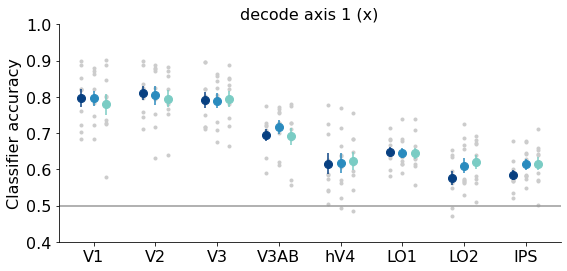

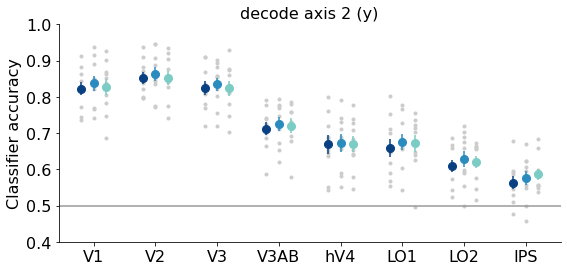

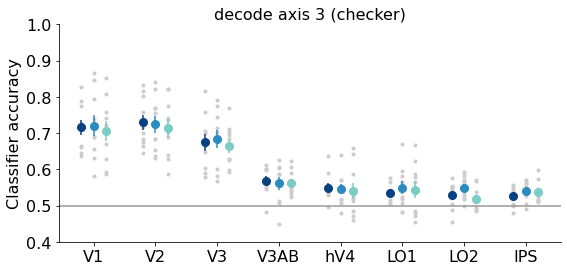

In [23]:
ti_plot = [0,1,2]
x_jitter = np.linspace(-0.2, 0.2, 3)

for bi, axis_name in enumerate(['axis 1 (x)', 'axis 2 (y)', 'axis 3 (checker)']):

    plt.figure(figsize=(9,4))

    
    ax = plt.subplot(1,1,1)

    avals = dec_withintask['acc_bytask'][:,:,:,bi]

    print(np.min(avals[:,:,ti_plot]))
    print(np.max(avals[:,:,ti_plot]))
    plt.axhline(1/2, color=[0.6, 0.6, 0.6])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], \
                         linestyle='none', zorder=10)
        lh.append(h)
        
        plt.plot(x_ticks, vals.T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
    

    plt.ylim([0.4, 1])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('Classifier accuracy')

    # plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s'%axis_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    figname = os.path.join(figfolder, 'binary_avg_categtasks_%s.pdf'%axis_name)
    print(figname)
    plt.savefig(figname)


#### stats


In [28]:
tasks_use = np.array([0,1,2])


for bi, bound_name in enumerate(bound_names):

    print(bound_name)

    vals = copy.deepcopy(dec_withintask['acc_bytask'][:,:,tasks_use,bi])

    anova_result = stats_utils.rmanova_2way(vals,['ROI','task'], do_shuffle=True, n_iter=10000, rndseed=968878)
    # anova_result = stats_utils.rmanova_2way(vals,['ROI','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'decodebinary_acc_rm_anova_%s.csv'%(bound_name))

    print(tablename)
                             
    anova_result.to_csv(tablename)
# stats_utils.rmanova_2way(vals,['ROI','task'], do_shuffle=False)

Decode: Linear (1)
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_acc_rm_anova_Decode: Linear (1).csv
Decode: Linear (2)
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_acc_rm_anova_Decode: Linear (2).csv
Decode: Checker
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_acc_rm_anova_Decode: Checker.csv


In [22]:
for bi, bound_name in enumerate(bound_names):

    print(bound_name)

    tablename = os.path.join(figfolder, 'decodebinary_acc_rm_anova_%s.csv'%(bound_name))

    print(tablename)
    
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for %s accuracy, all trials'%(bound_name))
    print(anova_result)

Decode: Linear (1)
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_acc_rm_anova_Decode: Linear (1).csv
Sat Dec 14 11:30:58 2024

Anova for Decode: Linear (1) accuracy, all trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       70.811579     7.0    63.0  0.0000           0.0000
task       0.832878     2.0    18.0  0.4509           0.4505
ROI:task   2.216250    14.0   126.0  0.0104           0.0099
Decode: Linear (2)
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_acc_rm_anova_Decode: Linear (2).csv
Sat Dec 14 11:36:05 2024

Anova for Decode: Linear (2) accuracy, all trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       87.643939     7.0    63.0  0.0000           0.0000
task       3.166569     2.0    18.0  0.0663           0.0672
ROI:task   0.283521    14.0   126.0  0.9949           0.9939
Decode: Checker
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_acc_rm_anova_Decode: Checke